<a href="https://colab.research.google.com/github/UniCandice/Ontology/blob/main/ontology_dict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install rdflib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.1/562.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.2/116.2 kB 11.6 MB/s eta 0:00:00


In [3]:
import os
import random
import pandas as pd
import numpy as np
from rdflib import Graph, Namespace, Literal, URIRef, RDF, RDFS

# Set number of cars to generate data for
num_cars = 10

# Initialize a dictionary to store the generated data
time_series_dict = {}

# Function to generate random time series data
def generate_time_series_data(num_points=100):
    time = np.linspace(0, 10, num_points)  # Simulate time from 0 to 10
    voltage = np.random.normal(3.8, 0.02, num_points)  # Simulate voltage data
    current = np.random.normal(0.15, 0.02, num_points)  # Simulate current data

    # Create a DataFrame
    df = pd.DataFrame({
        'Time': time,
        'Voltage': voltage,
        'Current': current
    })
    return df

# Function to generate random metadata
def generate_metadata(car_number):
    label = random.choice(['00', '01'])  # Simulate a label (00: no fault, 01: fault)
    mileage = random.randint(1000, 100000)  # Simulate mileage
    charge_segment = random.randint(1, 5)  # Simulate charge segment number

    metadata = {
        'car': car_number,
        'label': label,
        'mileage': mileage,
        'segment': charge_segment,
        'columns': ['Time', 'Voltage', 'Current']
    }
    return metadata

# Generate data for 10 cars
for car_num in range(1, num_cars + 1):
    car_number = f'car_{car_num}'  # Car number as a string (e.g., 'car_1', 'car_2')

    # Generate random time series data and metadata
    time_series_data = generate_time_series_data()
    metadata = generate_metadata(car_number)

    # Store DataFrame and metadata in the dictionary
    time_series_dict[car_number] = {
        'data': time_series_data,
        'metadata': metadata
    }

# Initialize RDF Graph
g = Graph()
# Define Namespace
ns = Namespace("http://example.org/battery#")

# Create OWL Classes
g.add((ns.Car, RDF.type, RDFS.Class))
g.add((ns.TimeSeriesData, RDF.type, RDFS.Class))
g.add((ns.Metadata, RDF.type, RDFS.Class))

# Add Data to the Graph
for car_number, content in time_series_dict.items():
    car_uri = URIRef(ns[car_number])

    # Add car instance
    g.add((car_uri, RDF.type, ns.Car))
    g.add((car_uri, ns.label, Literal(content['metadata']['label'])))
    g.add((car_uri, ns.mileage, Literal(content['metadata']['mileage'])))
    g.add((car_uri, ns.charge_segment, Literal(content['metadata']['segment'])))

    # Add time series data
    time_series_uri = URIRef(ns[f"{car_number}_time_series"])
    g.add((time_series_uri, RDF.type, ns.TimeSeriesData))

    for index, row in content['data'].iterrows():
        g.add((time_series_uri, ns.hasTimePoint, Literal(row['Time'])))
        g.add((time_series_uri, ns.hasVoltage, Literal(row['Voltage'])))
        g.add((time_series_uri, ns.hasCurrent, Literal(row['Current'])))

# Serialize the graph to RDF/XML format
owl_file_path = 'time_series_data.owl'
g.serialize(destination=owl_file_path, format='xml')

print(f"OWL file created at: {owl_file_path}")



OWL file created at: time_series_data.owl


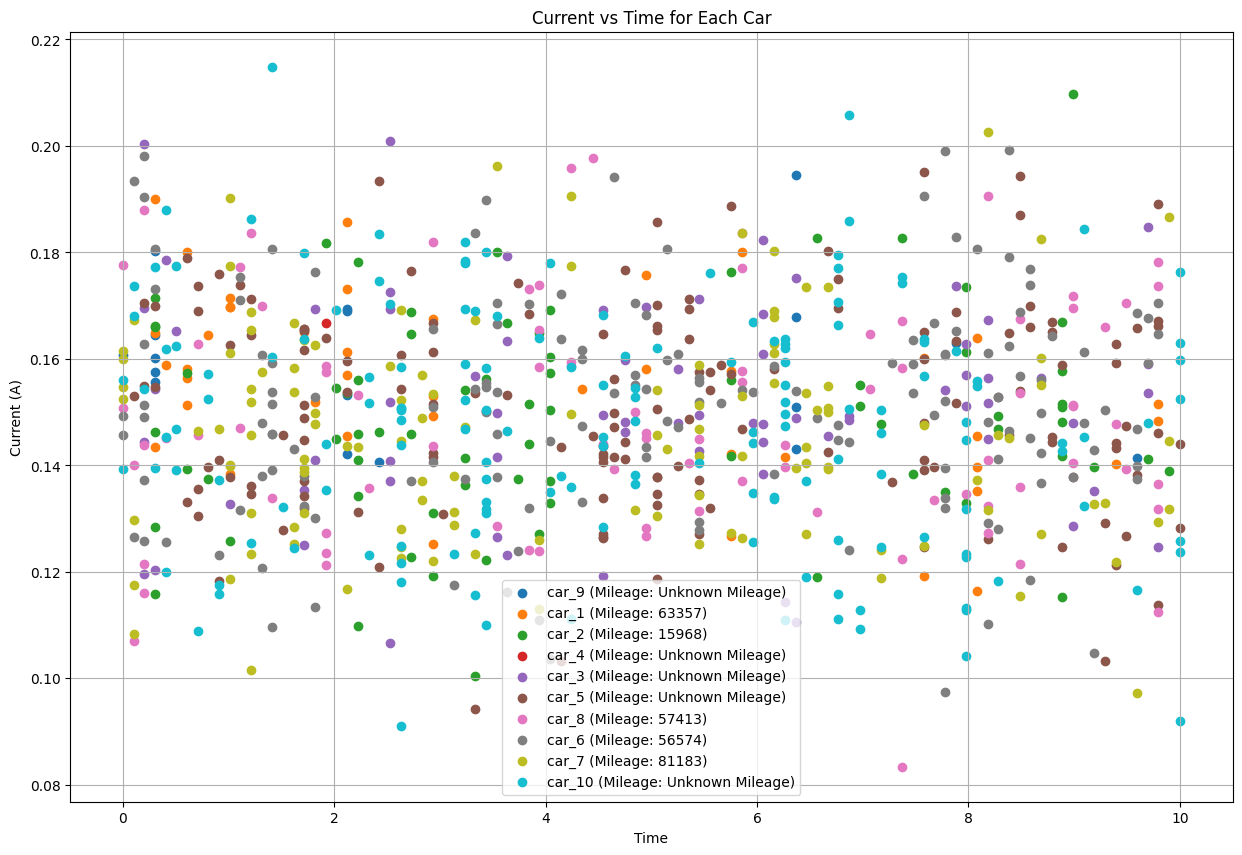

In [6]:
import matplotlib.pyplot as plt
from rdflib import Graph, Namespace
import pandas as pd

# Define Namespace
ns = Namespace("http://example.org/battery#")

# Load the OWL file
owl_file_path = 'time_series_data.owl'  # Adjust the path as necessary
g = Graph()
g.parse(owl_file_path)

# Initialize a dictionary to store the data extracted from the OWL file
time_series_dict = {}

# Iterate through the triples in the graph to extract data
for s, p, o in g:
    # Extract car number from the URI
    if p == ns.label:  # Assuming `label` is the property for car number
        car_number = str(s).split('#')[-1]  # Extract car number from URI

        # Initialize car data structure in the dictionary if not already done
        if car_number not in time_series_dict:
            time_series_dict[car_number] = {
                'data': [],
                'metadata': {}
            }

    # Extract metadata for the car only if the car_number is initialized
    if car_number in time_series_dict:
        if p == ns.mileage:
            time_series_dict[car_number]['metadata']['mileage'] = o.toPython()
        elif p == ns.charge_segment:
            time_series_dict[car_number]['metadata']['segment'] = o.toPython()
        elif p == ns.label:  # This is for the fault label
            time_series_dict[car_number]['metadata']['label'] = o.toPython()

    # Extract time series data
    if p == ns.hasTimePoint:  # Assuming this is how time points are defined
        time_value = o.toPython()  # Get time value
    elif p == ns.hasCurrent:  # Assuming this is how current values are defined
        current_value = o.toPython()  # Get current value

        # Check if the car number has been initialized
        if car_number in time_series_dict:
            # Append time and current to the data list only if both are available
            if 'time_value' in locals() and 'current_value' in locals():
                time_series_dict[car_number]['data'].append((time_value, current_value))
            else:
                print(f"Missing time or current value for {car_number} at time {time_value if 'time_value' in locals() else 'N/A'}.")

# Convert the data list to DataFrame for each car
for car_number, content in time_series_dict.items():
    # Create DataFrame from the list of tuples
    if content['data']:  # Check if there's any data
        content['data'] = pd.DataFrame(content['data'], columns=['Time', 'Current'])
    else:
        print(f"No data available for {car_number}.")

# Function to plot current vs time for each car with mileage
def plot_current_vs_time(time_series_dict):
    plt.figure(figsize=(15, 10))  # Set the figure size

    # Iterate through the cars in the dictionary
    for car_number, content in time_series_dict.items():
        if 'data' in content and not content['data'].empty:  # Check if data exists
            df = content['data']  # Get the time series data DataFrame
            mileage = content['metadata'].get('mileage', 'Unknown Mileage')  # Get mileage

            # Plot current vs time
            plt.scatter(df['Time'], df['Current'], label=f'{car_number} (Mileage: {mileage})')
        else:
            print(f"No complete data to plot for {car_number}.")

    # Customize the plot
    plt.title('Current vs Time for Each Car')
    plt.xlabel('Time')
    plt.ylabel('Current (A)')
    plt.legend()
    plt.grid()
    plt.show()

# Call the function to plot
plot_current_vs_time(time_series_dict)



